### Import

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist 
from tqdm.notebook import tqdm
np.set_printoptions(suppress=True)

In [2]:
from sklearn.utils.extmath import row_norms, safe_sparse_dot, stable_cumsum
from sklearn.utils import check_random_state
from sklearn.utils import check_array
from sklearn.metrics.pairwise import euclidean_distances as _euclidean_distances
from sklearn.cluster import KMeans
import scipy.sparse as sp

### Functions

In [3]:
def _kmpp(X, n_clusters, x_squared_norms, random_state, n_local_trials=None):
    """Computational component for initialization of n_clusters by
    k-means++. Prior validation of data is assumed.
    Parameters
    ----------
    X : {ndarray, sparse matrix} of shape (n_samples, n_features)
        The data to pick seeds for.
    n_clusters : int
        The number of seeds to choose.
    x_squared_norms : ndarray of shape (n_samples,)
        Squared Euclidean norm of each data point.
    random_state : RandomState instance
        The generator used to initialize the centers.
        See :term:`Glossary <random_state>`.
    n_local_trials : int, default=None
        The number of seeding trials for each center (except the first),
        of which the one reducing inertia the most is greedily chosen.
        Set to None to make the number of trials depend logarithmically
        on the number of seeds (2+log(k)); this is the default.
    Returns
    -------
    centers : ndarray of shape (n_clusters, n_features)
        The initial centers for k-means.
    indices : ndarray of shape (n_clusters,)
        The index location of the chosen centers in the data array X. For a
        given index and center, X[index] = center.
    """
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly and track index of point
    center_id = random_state.randint(n_samples)
    indices = np.full(n_clusters, -1, dtype=int)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]
    indices[0] = center_id

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = _euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms, squared=True
    )
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.uniform(size=n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq), rand_vals)
        # XXX: numerical imprecision can result in a candidate_id out of range
        np.clip(candidate_ids, None, closest_dist_sq.size - 1, out=candidate_ids)

        # Compute distances to center candidates
        distance_to_candidates = _euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True
        )

        # update closest distances squared and potential for each candidate
        np.minimum(closest_dist_sq, distance_to_candidates, out=distance_to_candidates)
        candidates_pot = distance_to_candidates.sum(axis=1)

        # Decide which candidate is the best
        best_candidate = np.argmin(candidates_pot)
        current_pot = candidates_pot[best_candidate]
        closest_dist_sq = distance_to_candidates[best_candidate]
        best_candidate = candidate_ids[best_candidate]

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]
        indices[c] = best_candidate

    return centers, indices


def kmpp_initializer(X, n_clusters, x_squared_norms=None, random_state=None, n_local_trials=None):
    """Init n_clusters seeds according to k-means++.
    .. versionadded:: 0.24
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The data to pick seeds from.
    n_clusters : int
        The number of centroids to initialize.
    x_squared_norms : array-like of shape (n_samples,), default=None
        Squared Euclidean norm of each data point.
    random_state : int or RandomState instance, default=None
        Determines random number generation for centroid initialization. Pass
        an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    n_local_trials : int, default=None
        The number of seeding trials for each center (except the first),
        of which the one reducing inertia the most is greedily chosen.
        Set to None to make the number of trials depend logarithmically
        on the number of seeds (2+log(k)).
    Returns
    -------
    centers : ndarray of shape (n_clusters, n_features)
        The initial centers for k-means.
    indices : ndarray of shape (n_clusters,)
        The index location of the chosen centers in the data array X. For a
        given index and center, X[index] = center.
    Notes
    -----
    Selects initial cluster centers for k-mean clustering in a smart way
    to speed up convergence. see: Arthur, D. and Vassilvitskii, S.
    "k-means++: the advantages of careful seeding". ACM-SIAM symposium
    on Discrete algorithms. 2007
    Examples
    --------
    >>> from sklearn.cluster import kmeans_plusplus
    >>> import numpy as np
    >>> X = np.array([[1, 2], [1, 4], [1, 0],
    ...               [10, 2], [10, 4], [10, 0]])
    >>> centers, indices = kmeans_plusplus(X, n_clusters=2, random_state=0)
    >>> centers
    array([[10,  4],
           [ 1,  0]])
    >>> indices
    array([4, 2])
    """

    # Check data
    check_array(X, accept_sparse="csr", dtype=[np.float64, np.float32])

    if X.shape[0] < n_clusters:
        raise ValueError(
            f"n_samples={X.shape[0]} should be >= n_clusters={n_clusters}."
        )

    # Check parameters
    if x_squared_norms is None:
        x_squared_norms = row_norms(X, squared=True)
    else:
        x_squared_norms = check_array(x_squared_norms, dtype=X.dtype, ensure_2d=False)

    if x_squared_norms.shape[0] != X.shape[0]:
        raise ValueError(
            f"The length of x_squared_norms {x_squared_norms.shape[0]} should "
            f"be equal to the length of n_samples {X.shape[0]}."
        )

    if n_local_trials is not None and n_local_trials < 1:
        raise ValueError(
            f"n_local_trials is set to {n_local_trials} but should be an "
            "integer value greater than zero."
        )

    random_state = check_random_state(random_state)

    # Call private k-means++
    centers, indices = _kmpp(
        X, n_clusters, x_squared_norms, random_state, n_local_trials
    )

    return centers, indices

In [4]:
def pocs_clustering(X, num_clusters, n_iterations):
    
    # Generate prototypes   
    centroids_init, _ = kmpp_initializer(X, num_clusters)
    
    # Finding the distance between centroids and all the data points
    distances = cdist(X, centroids_init ,'euclidean') # Step 2

    # Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) # Step 3
    saved_points = points.copy()

    for ite in range(n_iterations):

        updated_prototypes = []

        for idx in range(num_clusters):

            cluster_idx_points = X[points==idx]    # get data points of a cluster

            dists = cdist([centroids_init[idx]], cluster_idx_points ,'euclidean')

            sum_dist = np.sum(dists)
            importances = dists/(sum_dist+0.000001)
            importances = np.transpose(importances)

            pre_centroid = centroids_init[idx].copy()  
            updated_centroid = centroids_init[idx].copy()

            moment = importances*(cluster_idx_points - pre_centroid)
            delta = np.sum(moment, axis=0)
            
            updated_centroid += delta
            updated_prototypes.append(updated_centroid)

        centroids_init = np.array(updated_prototypes)

        # Finding the distance between centroids and all the data points
        distances = cdist(X, centroids_init ,'euclidean') # Step 2

        # Centroid with the minimum Distance
        points = np.array([np.argmin(i) for i in distances]) # Step 3

        difference = np.sum(saved_points-points)

        if difference == 0:
            print(f'Converged after {ite} iterations!')
            break

        else:
            saved_points = points.copy()
            
    return centroids_init, points

### Demo

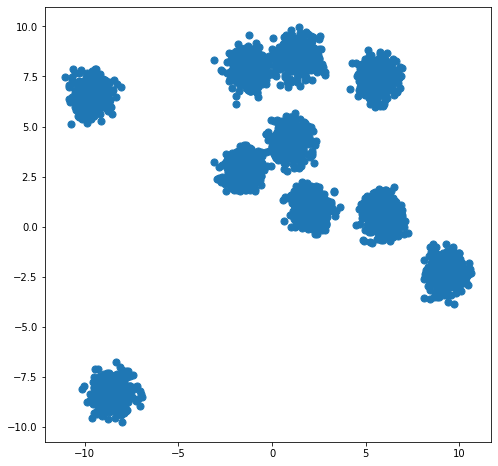

In [5]:
num_clusters = 10
X, y = make_blobs(n_samples=5000, centers=num_clusters, cluster_std=0.5, random_state=0)

plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

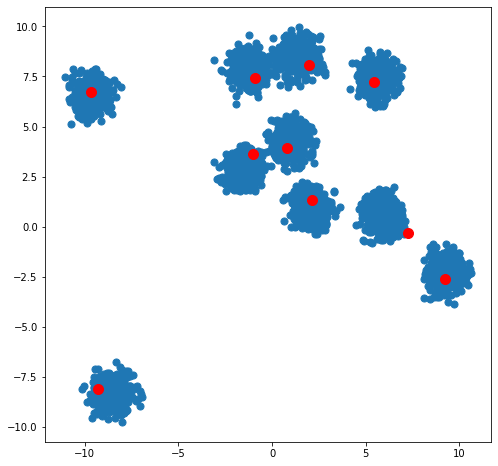

In [6]:
candidates, _ = kmpp_initializer(X, num_clusters)
# print(candidates)
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.scatter(candidates[:, 0], candidates[:, 1], c='red',s=100)
plt.show()

Converged after 3 iterations!
0.04488039016723633


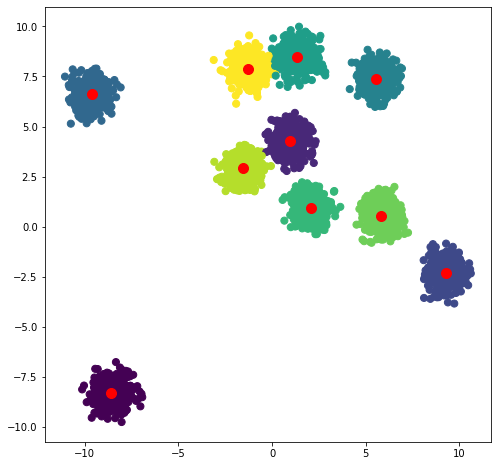

In [7]:
# POSC-based Clustering Algorithm Demo
start_time = time.time()
centroids, labels = pocs_clustering(X, num_clusters, 100)
end_time = time.time()
proc_time = end_time - start_time
print(proc_time)

# Track results
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red')
plt.show()